

# **Member**
*   林家誠, 109306066, MIS
*   陳彥竹, 1093060xx, MIS



# **Title**
**url之分析...**

# **Problem Definition**
**Problem Definition**

# **Dataset**
**Dataset**
**介紹**



# **description of your models**
**models**
**介紹**



# **result**
**介紹**



# **discussion**
**介紹**


# 程式碼

## 安裝套件

In [1]:
!pip install transformers
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 下載和解壓檔案

In [2]:
import requests
import zipfile

url = 'https://github.com/Tonyrj3268/DS4CS-FinalProject/raw/main/archive.zip'
response = requests.get(url)
with open('archive.zip', 'wb') as file:
    file.write(response.content)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 加載模組

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import string
from urllib.parse import urlparse
import re
from transformers import BertModel, BertTokenizer
import torch
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## gpu check

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 分析資料集

In [5]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


由於資料集的label分配不均，且資料太過龐大(65萬筆)，使用欠採樣平衡數據集並且縮小訓練資料量，display = True僅供助教和展示時使用(限縮資料量成1萬筆)，原本呈現之結果為欠採樣後之訓練數量。


In [53]:
display = False

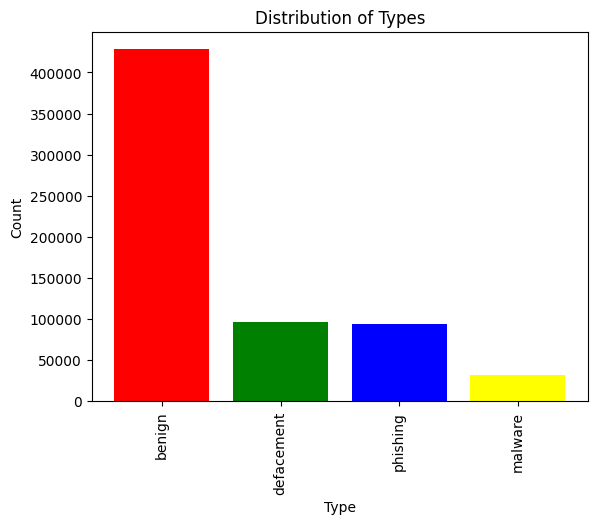

In [7]:
category_counts = df['type'].value_counts()
colors = ['red', 'green', 'blue', 'yellow']
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Types")
plt.xticks(rotation='vertical')
plt.show()

In [54]:
X = df[['url']]
y = df['type']

under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

print("處理後的樣本數:", len(X_resampled))
print("處理後的樣本分佈:")
print(y_resampled.value_counts())

re_df = pd.concat([X_resampled, y_resampled], axis=1)
if display:
  re_df = re_df.sample(n=10000, random_state=42)

處理後的樣本數: 130080
處理後的樣本分佈:
benign        32520
defacement    32520
malware       32520
phishing      32520
Name: type, dtype: int64


# 預處理

## 特殊字符
計算特殊字符之數量，若完全沒該字符出現，則捨棄此字符欄位。

In [55]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=',\
         '{', '}', '[', ']', '|', '\\', ':', ';', '<', '>', ',', '.', '?', '/', '`', '~']  # 定义特殊字符列表

for a in special_chars:
    re_df[a] = re_df['url'].apply(lambda i: i.count(a))
absent_chars = [char for char in special_chars if re_df[char].sum() == 0]
re_df.drop(columns=absent_chars, inplace=True)

## https 檢查 & url長度計算
檢查是否帶有https字串，如有則計為1。
計算url之總長度

In [56]:
def httpSecure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        return 1
    else:
        return 0
re_df['https'] = re_df['url'].apply(lambda i: httpSecure(i))
re_df['url_len'] = re_df['url'].apply(lambda i: len(str(i)))

min_value = re_df['url_len'].min()
max_value = re_df['url_len'].max()
re_df['url_len'] = re_df['url_len'].apply(lambda i: (i - min_value) / (max_value - min_value))

In [57]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130080 entries, 0 to 130079
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   url      130080 non-null  object
 1   type     130080 non-null  object
 2   !        130080 non-null  int64 
 3   @        130080 non-null  int64 
 4   #        130080 non-null  int64 
 5   $        130080 non-null  int64 
 6   %        130080 non-null  int64 
 7   ^        130080 non-null  int64 
 8   &        130080 non-null  int64 
 9   *        130080 non-null  int64 
 10  (        130080 non-null  int64 
 11  )        130080 non-null  int64 
 12  _        130080 non-null  int64 
 13  -        130080 non-null  int64 
 14  +        130080 non-null  int64 
 15  =        130080 non-null  int64 
 16  {        130080 non-null  int64 
 17  }        130080 non-null  int64 
 18  [        130080 non-null  int64 
 19  ]        130080 non-null  int64 
 20  |        130080 non-null  int64 
 21  \        1

## 加載bert模型

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')#bert-base-uncased
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 切割url
1.  將url的特殊字符去除，獲得剩餘單字詞的集合，例如:www.example.com => [www, example, com]。
2.  使用已訓練好的tokenizer獲得單詞之token ID，將token集合放入bert 模型生成1維768長度的值
3.  display mode預估訓練時間3分半

In [59]:
def urlSplitBatch(urls):
    url_parts = [re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', ' ', url)).split(' ') for url in urls]
    tokens = [tokenizer.batch_encode_plus(parts, padding=True, truncation=True, return_tensors='pt') for parts in url_parts]
    input_ids = [token["input_ids"] for token in tokens]
    url_vectors = []
    for ids in input_ids:
      with torch.no_grad():
          ids = ids.to(device)
          last_hidden_states = model(ids)[0]
      url_vectors.append(last_hidden_states.mean(dim=[0, 1]).unsqueeze(0))

    url_vectors = torch.cat(url_vectors, dim=0).to(device)
    return url_vectors


# 在主要迴圈中使用批次處理
BATCH_SIZE = 1000 # 你可以根據你的硬體配置和需求來調整批次的大小
word_vector = []
rows_to_drop = []
total = len(re_df['url'])
checkpoint = total // 100
for start in range(0, total, BATCH_SIZE):
  end = min(start + BATCH_SIZE, total)
  batch_indices = re_df.index[start:end]
  batch = re_df['url'].loc[batch_indices]
  try:
    split_urls = urlSplitBatch(batch)  # 對整個批次進行split操作
  except:
    print(f"第{start}批資料集發生錯誤，跳過並移除")
    rows_to_drop.extend(batch_indices)  # 若split操作失敗，將整個批次的索引加入要刪除的列表
    continue

  list_from_tensor = split_urls.tolist()
  word_vector.extend(list_from_tensor)

  if end % checkpoint == 0:
      print("已完成：{:.0f}%".format(end / total * 100))

已完成：10%
已完成：20%
已完成：30%
已完成：40%
已完成：50%
已完成：60%
已完成：70%
已完成：80%
已完成：90%
已完成：100%


## 使用AutoEncoder降維
將BERT編碼後的矩陣降至200維

In [60]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        mid_dim = (input_dim + encoding_dim) // 2  # add an intermediate layer with average dimension

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, encoding_dim),
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, input_dim),
        )

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x


In [61]:
input_dim = len(word_vector[0])  # number of features
encoding_dim = 200  # desired dimension after encoding

model = AutoEncoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
EPOCHES = 20

features = torch.from_numpy(np.array(word_vector)).float().to(device)
dataset = TensorDataset(features)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

for epoch in range(EPOCHES):
    for feature in data_loader:
        # forward
        outputs = model(feature[0])
        loss = criterion(outputs, feature[0])

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{EPOCHES}], Loss: {loss.item():.4f}')
with torch.no_grad():
    encoded_data = model.encoder(features)

Epoch [1/20], Loss: 0.0022
Epoch [2/20], Loss: 0.0015
Epoch [3/20], Loss: 0.0009
Epoch [4/20], Loss: 0.0009
Epoch [5/20], Loss: 0.0009
Epoch [6/20], Loss: 0.0005
Epoch [7/20], Loss: 0.0005
Epoch [8/20], Loss: 0.0006
Epoch [9/20], Loss: 0.0006
Epoch [10/20], Loss: 0.0006
Epoch [11/20], Loss: 0.0009
Epoch [12/20], Loss: 0.0005
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0006
Epoch [15/20], Loss: 0.0007
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0007
Epoch [18/20], Loss: 0.0006
Epoch [19/20], Loss: 0.0006
Epoch [20/20], Loss: 0.0005


## 切分成3種特徵
1.  純單字詞矩陣
2.  純原url之特徵矩陣
3.  上面兩種之結合

In [62]:
word_vector_array = encoded_data.cpu()
feature_array = re_df.drop(['url', 'type'], axis=1).drop(rows_to_drop).to_numpy()
merged_array = np.hstack((feature_array, word_vector_array))

target = pd.get_dummies(re_df['type'], columns=['type'])

# 模型訓練

## scikit-learn 模型訓練
使用決策樹和隨機森林和XGBClassifier分別對3種特徵進行訓練

In [17]:
feature_arrays = [feature_array, word_vector_array, merged_array]
feature_name = ["feature_array", "word_vector_array", "merged_array"]
models = [DecisionTreeClassifier(), RandomForestClassifier(n_jobs=-1),XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')]

print("{:<20s} {:<20s} {:<10s}".format("特徵", "模型", "準確率"))
print("="*50)

for i,features in enumerate(feature_arrays):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    for model in models:
        classifier = model

        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        accuracy = classifier.score(X_test, y_test)

        print("{:<20s} {:<20s} {:.4f}".format(feature_name[i], model.__class__.__name__, accuracy))

print("="*50)

特徵                   模型                   準確率       
feature_array        DecisionTreeClassifier 0.8070


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


feature_array        RandomForestClassifier 0.8370
feature_array        XGBClassifier        0.8405
word_vector_array    DecisionTreeClassifier 0.6600
word_vector_array    RandomForestClassifier 0.6230
word_vector_array    XGBClassifier        0.7270
merged_array         DecisionTreeClassifier 0.8065
merged_array         RandomForestClassifier 0.7900
merged_array         XGBClassifier        0.8720


## 神經網路
使用神經網路對三種資料集進行訓練

In [63]:
class FeatureNet(nn.Module):
    def __init__(self, x_len):
        super(FeatureNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.log_softmax(self.fc3(x), dim=1)
        return x
class WordNet(nn.Module):
    def __init__(self, x_len):
        super(WordNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 600)
        self.bn1 = nn.BatchNorm1d(600)
        self.fc2 = nn.Linear(600, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc5 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = torch.log_softmax(self.fc5(x), dim=1)  # 使用 LogSoftmax
        return x

## 引入早停機制
如果驗證集的LOSS連續5個EPCHOES沒下降，即停止訓練

In [64]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [66]:
feature_arrays = [feature_array, word_vector_array, merged_array]
mymodels = [FeatureNet(len(feature_array[0])), WordNet(len(word_vector_array[0])), WordNet(len(merged_array[0]))]
feature_names = ["Feature Array", "Word Vector Array", "Merged Array"]
Epoch = 30
loss_results = {}
accuracy_results = {}
loss_results_val = {}
accuracy_results_val = {}

for model, feature_name, features in zip(mymodels, feature_names, feature_arrays):
  early_stopping = EarlyStopping(patience=5, verbose=True)
  print(f"\nTraining model with: {feature_name}\n")
  features_train, features_test, labels_train, labels_test = train_test_split(features, target.values, test_size=0.2, random_state=42)
  features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

  # numpy轉換tensors
  features_train = torch.tensor(features_train, dtype=torch.float32)
  labels_train = torch.tensor(labels_train, dtype=torch.float32)
  features_val = torch.tensor(features_val, dtype=torch.float32)
  labels_val = torch.tensor(labels_val, dtype=torch.float32)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  labels_test = torch.tensor(labels_test, dtype=torch.float32)

  train_dataset = TensorDataset(features_train, labels_train)
  val_dataset = TensorDataset(features_val, labels_val)
  test_dataset = TensorDataset(features_test, labels_test)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  net = model.to(device)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(net.parameters())

  losses = []
  accuracies = []
  losses_val = []
  accuracies_val = []

  for epoch in range(Epoch):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.argmax(dim=1).to(device)
      outputs = net(inputs)

      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    accuracies.append(train_accuracy)
    train_loss = running_loss / len(train_dataloader)
    losses.append(train_loss)
    print(f'[{feature_name}] Epoch {epoch + 1}, Training Loss: {train_loss}')

    # Validation step
    running_loss = 0.0
    val_accuracy = 0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    accuracies_val.append(val_accuracy)
    val_loss = running_loss / len(val_dataloader)
    losses_val.append(val_loss)
    print(f'[{feature_name}] Epoch {epoch + 1}, Validation Loss: {val_loss}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    net.train()  # Reset the model to training mode

  # Save the average loss and accuracy for this feature
  loss_results[feature_name] = losses
  accuracy_results[feature_name] = accuracies
  loss_results_val[feature_name] = losses_val
  accuracy_results_val[feature_name] = accuracies_val



# Test the model
net.eval()  # It's important to set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.argmax(dim=1).to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'[{feature_name}] Test data, Accuracy: {accuracy}')
print('Finished Training')


Training model with: Feature Array

[Feature Array] Epoch 1, Training Loss: 0.7641895894908979
[Feature Array] Epoch 1, Validation Loss: 0.6411446625012561
[Feature Array] Epoch 2, Training Loss: 0.5511139134184202
[Feature Array] Epoch 2, Validation Loss: 0.4959420392666858
[Feature Array] Epoch 3, Training Loss: 0.4824678371334699
[Feature Array] Epoch 3, Validation Loss: 0.4648429941088875
[Feature Array] Epoch 4, Training Loss: 0.4479980160418517
[Feature Array] Epoch 4, Validation Loss: 0.4521718500581987
[Feature Array] Epoch 5, Training Loss: 0.42822813231792933
[Feature Array] Epoch 5, Validation Loss: 0.43731873029945817
[Feature Array] Epoch 6, Training Loss: 0.4134565926143337
[Feature Array] Epoch 6, Validation Loss: 0.4041336768883869
[Feature Array] Epoch 7, Training Loss: 0.40226717526916356
[Feature Array] Epoch 7, Validation Loss: 0.4174880017212198
EarlyStopping counter: 1 out of 5
[Feature Array] Epoch 8, Training Loss: 0.39251293442416063
[Feature Array] Epoch 8, V

<ipython-input-66-8822f96f7b88>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_train = torch.tensor(features_train, dtype=torch.float32)
<ipython-input-66-8822f96f7b88>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_val = torch.tensor(features_val, dtype=torch.float32)
<ipython-input-66-8822f96f7b88>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_test = torch.tensor(features_test, dtype=torch.float32)


[Word Vector Array] Epoch 1, Training Loss: 0.5877692942592752
[Word Vector Array] Epoch 1, Validation Loss: 0.4237710200935785
[Word Vector Array] Epoch 2, Training Loss: 0.4739540868612732
[Word Vector Array] Epoch 2, Validation Loss: 0.4085825715968214
[Word Vector Array] Epoch 3, Training Loss: 0.4340046398187032
[Word Vector Array] Epoch 3, Validation Loss: 0.3544431206730246
[Word Vector Array] Epoch 4, Training Loss: 0.4066468570481622
[Word Vector Array] Epoch 4, Validation Loss: 0.32178423188032546
[Word Vector Array] Epoch 5, Training Loss: 0.3886359590896728
[Word Vector Array] Epoch 5, Validation Loss: 0.3281264865508109
EarlyStopping counter: 1 out of 5
[Word Vector Array] Epoch 6, Training Loss: 0.371799419966915
[Word Vector Array] Epoch 6, Validation Loss: 0.30154604464769363
[Word Vector Array] Epoch 7, Training Loss: 0.36020862047118835
[Word Vector Array] Epoch 7, Validation Loss: 0.2939983718554301
[Word Vector Array] Epoch 8, Training Loss: 0.3502669616514312
[Word

## 特別訓練
1. 先訓練完Word Vector的模型，生成出訓練集每個url的4種類別機率，將其與Feature Array進行合成，並且再次訓練。
2. 反過來做一遍

In [67]:
for arr in ["WtoF","FtoW"]:

  if arr == "WtoF":
    mymodels[1].eval()
    res = mymodels[1](torch.tensor(word_vector_array, dtype=torch.float32).to(device))
    combined_array = np.concatenate([feature_array, res.cpu().detach().numpy()], axis=1)
  else:
    mymodels[0].eval()
    res = mymodels[0](torch.tensor(feature_array, dtype=torch.float32).to(device))
    combined_array = np.concatenate([word_vector_array, res.cpu().detach().numpy()], axis=1)

  early_stopping = EarlyStopping(patience=5, verbose=True)
  print(f"\nTraining model with: {feature_name}\n")
  features_train, features_test, labels_train, labels_test = train_test_split(combined_array, target.values, test_size=0.2, random_state=42)
  features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42)

  # numpy轉換tensors
  features_train = torch.tensor(features_train, dtype=torch.float32)
  labels_train = torch.tensor(labels_train, dtype=torch.float32)
  features_val = torch.tensor(features_val, dtype=torch.float32)
  labels_val = torch.tensor(labels_val, dtype=torch.float32)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  labels_test = torch.tensor(labels_test, dtype=torch.float32)

  train_dataset = TensorDataset(features_train, labels_train)
  val_dataset = TensorDataset(features_val, labels_val)
  test_dataset = TensorDataset(features_test, labels_test)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  net = FeatureNet(len(combined_array[0])).to(device)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(net.parameters())

  losses = []
  accuracies = []
  losses_val = []
  accuracies_val = []
  Epoch = 30
  for epoch in range(Epoch):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.argmax(dim=1).to(device)
      outputs = net(inputs)

      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    accuracies.append(train_accuracy)
    train_loss = running_loss / len(train_dataloader)
    losses.append(train_loss)
    print(f'[{feature_name}] Epoch {epoch + 1}, Training Loss: {train_loss}')

    # Validation step
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    accuracies_val.append(val_accuracy)
    val_loss = running_loss / len(val_dataloader)
    losses_val.append(val_loss)
    print(f'[{feature_name}] Epoch {epoch + 1}, Validation Loss: {val_loss}')
    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    net.train()  # Reset the model to training mode
  loss_results[f"Conbined array {arr}"] = losses
  accuracy_results[f"Conbined array {arr}"] = accuracies
  loss_results_val[f"Conbined array {arr}"] = losses_val
  accuracy_results_val[f"Conbined array {arr}"] = accuracies_val

net.eval()  # It's important to set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.argmax(dim=1).to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'[Epoch {epoch + 1}, Accuracy: {accuracy}')

<ipython-input-67-cffeb03f1999>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = mymodels[1](torch.tensor(word_vector_array, dtype=torch.float32).to(device))



Training model with: Merged Array

[Merged Array] Epoch 1, Training Loss: 0.18090835812112901
[Merged Array] Epoch 1, Validation Loss: 0.20112202252529882
[Merged Array] Epoch 2, Training Loss: 0.13729577628948614
[Merged Array] Epoch 2, Validation Loss: 0.20368744512917075
EarlyStopping counter: 1 out of 5
[Merged Array] Epoch 3, Training Loss: 0.13274229503309012
[Merged Array] Epoch 3, Validation Loss: 0.19405769067673595
[Merged Array] Epoch 4, Training Loss: 0.12993085674145513
[Merged Array] Epoch 4, Validation Loss: 0.19191759407657422
[Merged Array] Epoch 5, Training Loss: 0.12491149491674161
[Merged Array] Epoch 5, Validation Loss: 0.1832098812664762
[Merged Array] Epoch 6, Training Loss: 0.12069356016854796
[Merged Array] Epoch 6, Validation Loss: 0.18438319516785306
EarlyStopping counter: 1 out of 5
[Merged Array] Epoch 7, Training Loss: 0.11795420196554483
[Merged Array] Epoch 7, Validation Loss: 0.1769333094347017
[Merged Array] Epoch 8, Training Loss: 0.11572864760489394

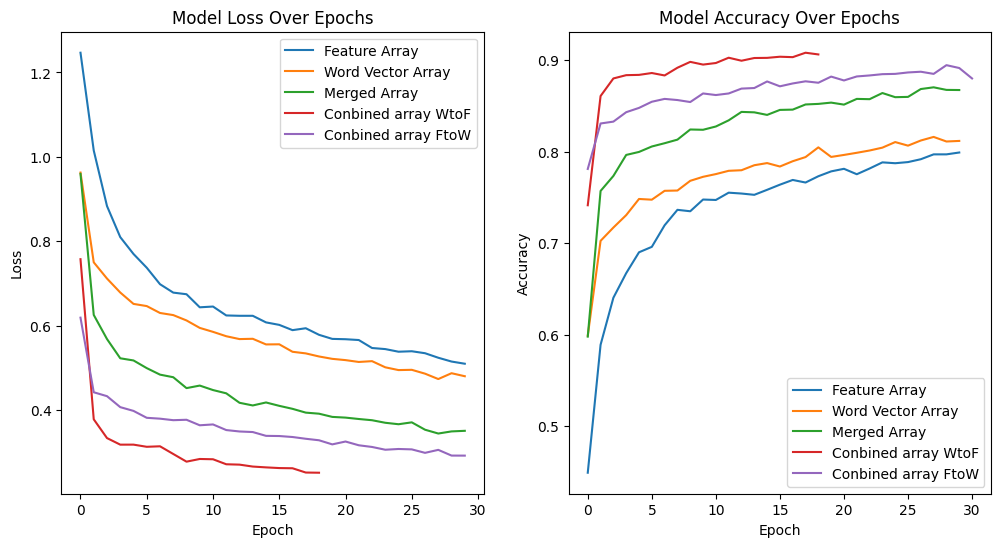

In [42]:
# Draw losses of all features in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for feature_name, losses in loss_results.items():
    plt.plot(losses, label=feature_name)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracies of all features in one graph
plt.subplot(1, 2, 2)
for feature_name, accuracies in accuracy_results.items():
    plt.plot(accuracies, label=feature_name)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

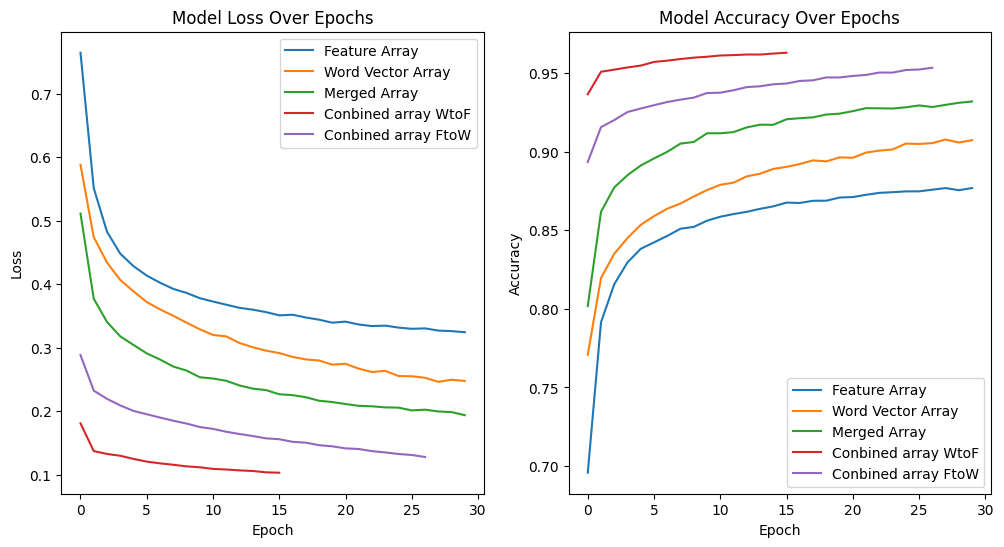

In [68]:
# Draw losses of all features in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for feature_name, losses in loss_results.items():
    plt.plot(losses, label=feature_name)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracies of all features in one graph
plt.subplot(1, 2, 2)
for feature_name, accuracies in accuracy_results.items():
    plt.plot(accuracies, label=feature_name)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [69]:
average_losses = {}
for feature, loss_array in loss_results.items():
    average_loss = sum(loss_array) / len(loss_array)
    average_losses[feature] = average_loss
sorted_features = sorted(average_losses.items(), key=lambda x: x[1])
top_three_features = [feature for feature, _ in sorted_features[:3]]

loss_results_val_and_train = {}
for feature in top_three_features:
  loss_results_val_and_train[feature] = {
        'train_loss': loss_results[feature],
        'val_loss': loss_results_val[feature]
    }
accuracy_results_val_and_train = {}
for feature in top_three_features:
  accuracy_results_val_and_train[feature] = {
        'train_acc': accuracy_results[feature],
        'val_acc': accuracy_results_val[feature]
    }

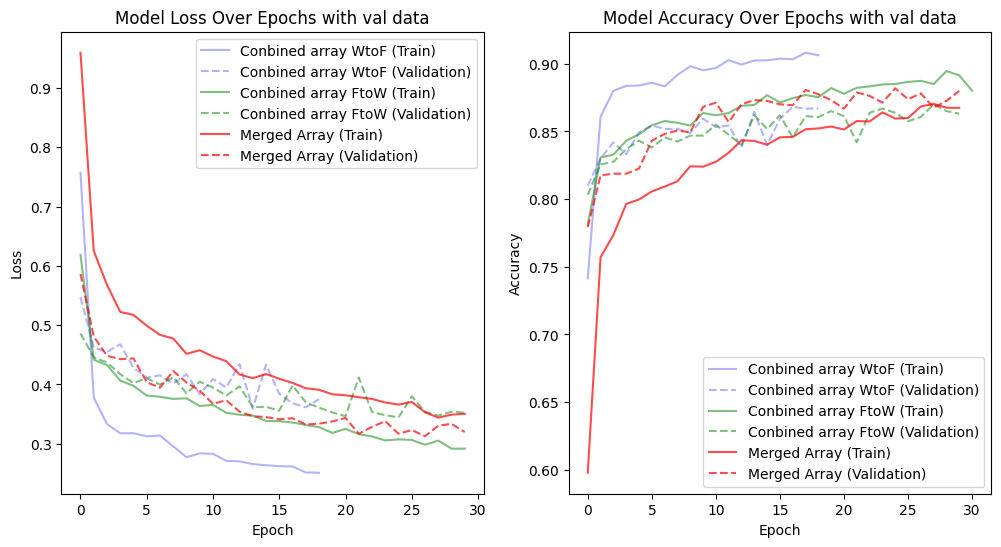

In [52]:
# 设置颜色和透明度
colors = ['b', 'g', 'r']
alpha_values = [0.3, 0.5, 0.7]

# 绘制损失图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, (feature_name, losses) in enumerate(loss_results_val_and_train.items()):
    train_losses = losses['train_loss']
    val_losses = losses['val_loss']
    color = colors[i]
    alpha = alpha_values[i]
    plt.plot(train_losses, color=color, alpha=alpha, label=f'{feature_name} (Train)')
    plt.plot(val_losses, color=color, alpha=alpha, linestyle='--', label=f'{feature_name} (Validation)')

plt.title('Model Loss Over Epochs with val data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率图
plt.subplot(1, 2, 2)
for i, (feature_name, accuracies) in enumerate(accuracy_results_val_and_train.items()):
    train_accuracies = accuracies['train_acc']
    val_accuracies = accuracies['val_acc']
    color = colors[i]
    alpha = alpha_values[i]
    plt.plot(train_accuracies, color=color, alpha=alpha, label=f'{feature_name} (Train)')
    plt.plot(val_accuracies, color=color, alpha=alpha, linestyle='--', label=f'{feature_name} (Validation)')

plt.title('Model Accuracy Over Epochs with val data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

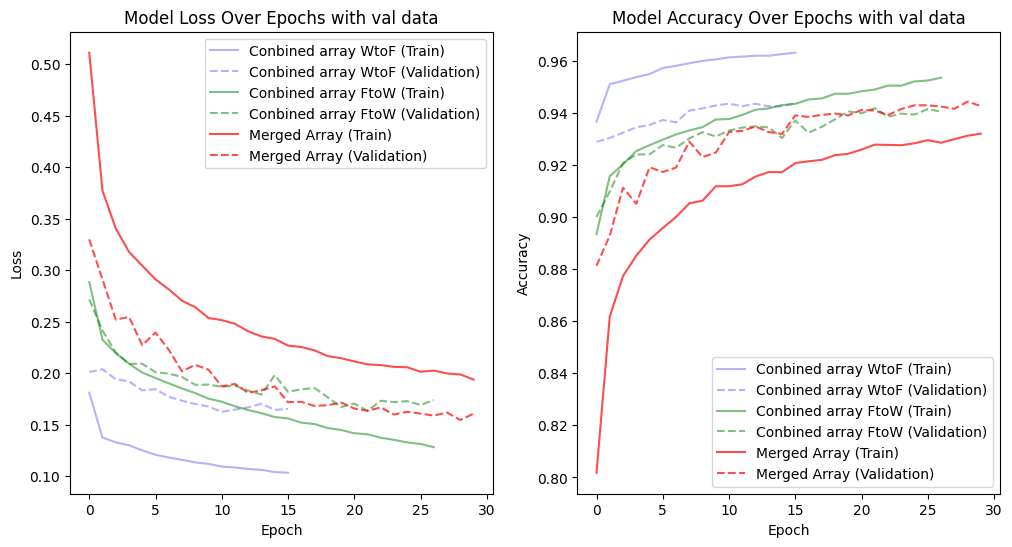

In [70]:
# 设置颜色和透明度
colors = ['b', 'g', 'r']
alpha_values = [0.3, 0.5, 0.7]

# 绘制损失图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, (feature_name, losses) in enumerate(loss_results_val_and_train.items()):
    train_losses = losses['train_loss']
    val_losses = losses['val_loss']
    color = colors[i]
    alpha = alpha_values[i]
    plt.plot(train_losses, color=color, alpha=alpha, label=f'{feature_name} (Train)')
    plt.plot(val_losses, color=color, alpha=alpha, linestyle='--', label=f'{feature_name} (Validation)')

plt.title('Model Loss Over Epochs with val data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率图
plt.subplot(1, 2, 2)
for i, (feature_name, accuracies) in enumerate(accuracy_results_val_and_train.items()):
    train_accuracies = accuracies['train_acc']
    val_accuracies = accuracies['val_acc']
    color = colors[i]
    alpha = alpha_values[i]
    plt.plot(train_accuracies, color=color, alpha=alpha, label=f'{feature_name} (Train)')
    plt.plot(val_accuracies, color=color, alpha=alpha, linestyle='--', label=f'{feature_name} (Validation)')

plt.title('Model Accuracy Over Epochs with val data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()